# Filter Model - Glaucoma Detection with VitaVision

This notebook presents the final implementation of a deep learning-powered filtering model developed as part of the machine learning pipeline for the VitaVision project. The filter model’s primary objective is to assess the quality and suitability of fundus images (bottom of the eye) for subsequent glaucoma detection.

It forms an essential step in the workflow, ensuring that only high-quality images are analyzed by the final diagnostic model. To achieve this, the model utilizes deep features extracted using a pretrained ResNet18 architecture, followed by classification through a Support Vector Machine (SVM) to determine whether an image is adequate for glaucoma analysis.


## Prepare the environment

### Install all the requirements


In [1]:
pip install torchvision opencv-python pillow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 33.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

### Import libraries

In [19]:
import os
import random
import shutil
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image, ImageEnhance
import numpy as np
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import joblib
import torch.nn as nn
from torchvision import models
from sklearn.model_selection import train_test_split

## Dataset Acquisition


In [27]:
Good_images=[]
Bad_images=[]
def show_images(images, num_samples=40, cols=8):
    plt.figure(figsize=(15,15))
    idx = int(len(images) / num_samples)

    for i, img in enumerate(images):
        if i % idx == 0:
            plt.subplot(int(num_samples/cols) + 1, cols, int(i/idx) + 1)
            plt.axis('off')
            plt.imshow(img)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout()
    plt.show()

### CIFAR Dataset

To simulate unsuitable images, we extracted 212 images from the CIFAR-10 public dataset, which includes various non-retinal images. These images were resized to 224×224 pixels and labeled as unsuitable for glaucoma detection.

In [28]:
transform_cifar = transforms.Compose([
    transforms.Resize((224, 224))
])

cifar_dataset = CIFAR10(root="./data", train=True, download=True, transform=transform_cifar)

for i in range(212):
    img, label = cifar_dataset[i]
    Bad_images.append(img)


### Proprietary Dataset
Images were captured using the custom-designed universal smartphone support, developed during this project to facilitate low-cost, portable retinal imaging. Initially, the dataset included 2 glaucoma-positive images and 10 non-glaucoma images. Through data augmentation, this dataset was expanded to 212 high-quality images, labeled as suitable for analysis.

In [29]:
Path_Glaucoma = "./data/1"
Path_NoGlaucoma = "./data/0"


def aumentar_imagen(imagen, n):
    aumentadas = []
    for _ in range(n):
        img = imagen.copy()
        if random.random() < 0.5:
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
        if random.random() < 0.5:
            img = img.transpose(Image.ROTATE_90)
        if random.random() < 0.5:
            enhancer = ImageEnhance.Brightness(img)
            img = enhancer.enhance(random.uniform(0.8, 1.2))
        aumentadas.append(img)
    return aumentadas

def cargar_y_aumentar(carpeta, factor, prefix):
    archivos = os.listdir(carpeta)
    for i, archivo in enumerate(archivos):
        ruta = os.path.join(carpeta, archivo)
        img = Image.open(ruta).convert("RGB").resize((224, 224))
        aumentadas = aumentar_imagen(img, factor)
        Good_images.extend(aumentadas)

cargar_y_aumentar(Path_Glaucoma, 50, "glaucoma")

cargar_y_aumentar(Path_NoGlaucoma, 10, "sano")


### Image Sample Visualization and distribution

To provide insight into the data used, a visual sample of the images included in the final dataset is presented in the corresponding code cell below.

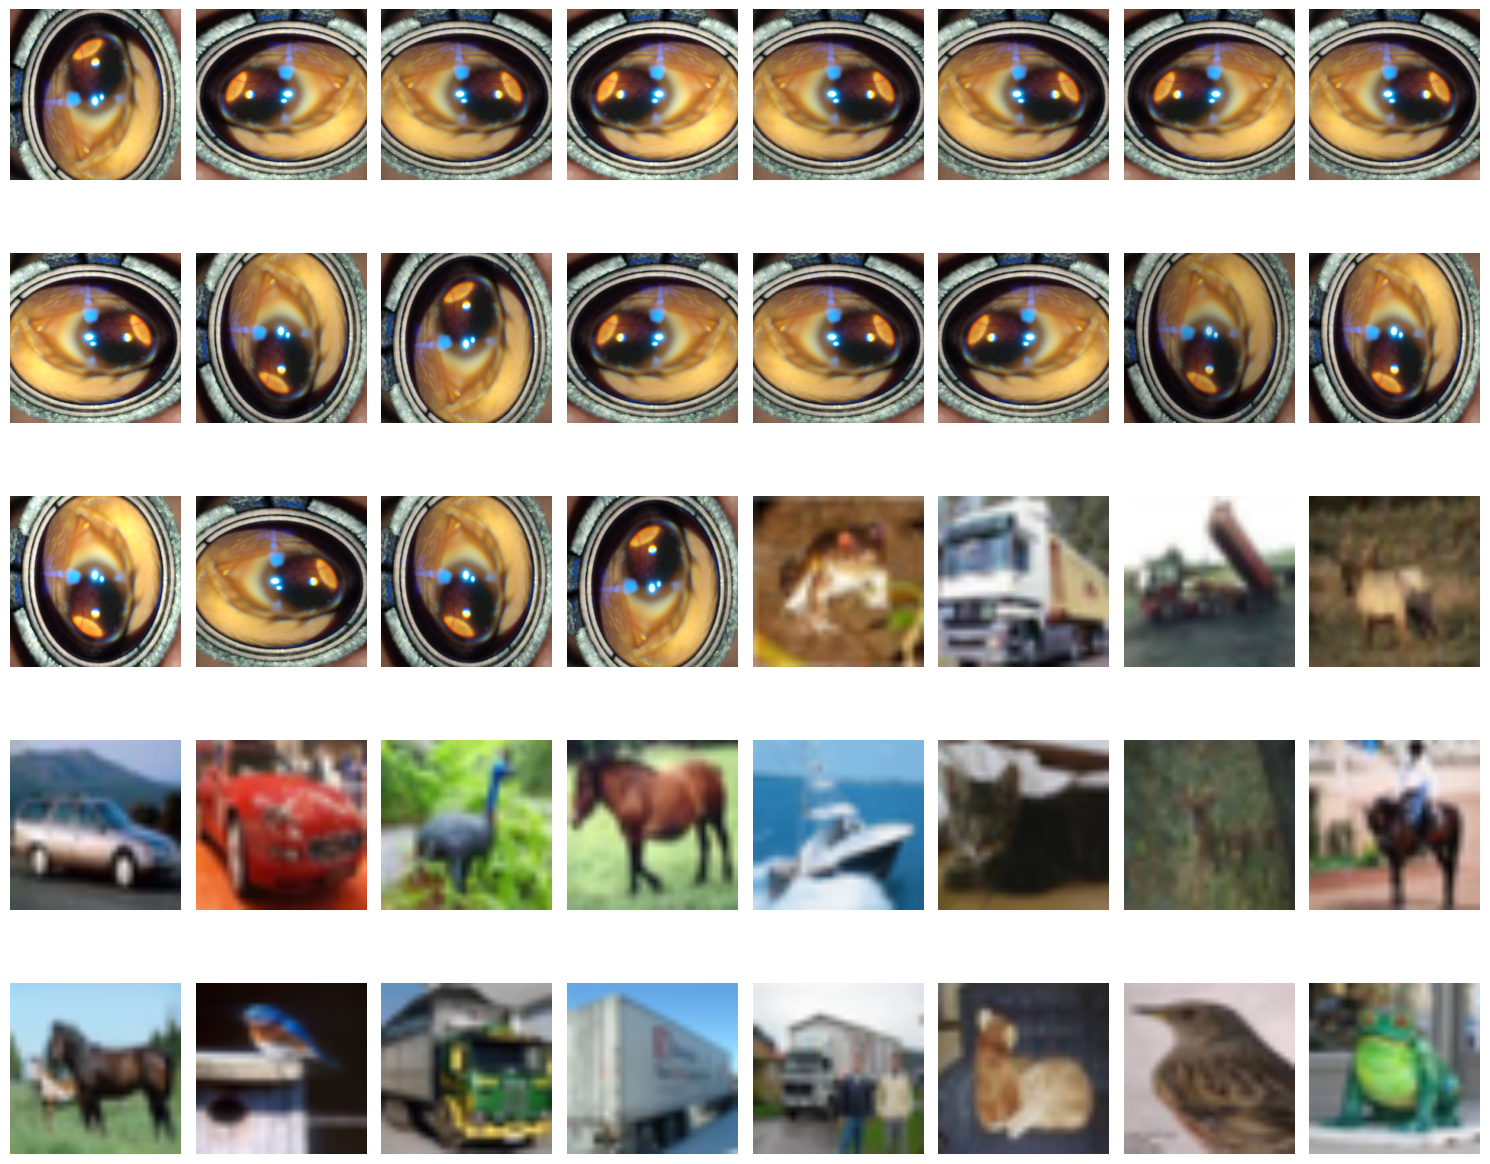

In [30]:
images_to_show = []
images_to_show.extend(Good_images[:20])
images_to_show.extend(Bad_images[:20])

show_images(images_to_show)

In [9]:
Size_good=len(Good_images)
Size_bad=len(Bad_images)

print("Distribution of images")
print(f'Size of all dataset {Size_bad+ Size_good}')
print(f'Size of good dataset {Size_good}')
print(f'Size of bad dataset {Size_bad}')


Distribution of images
Size of all dataset 424
Size of good dataset 212
Size of bad dataset 212


## Dataset Processing

In this section, we join all the images (Good_images and Bad_Images) and this are underwent preprocessing which included:

- Resizing all images to 224×224 pixels.
- Convert to Tensor

Second, We extract the feactures of the tensor with a deep learning architecture pretrain ResNet

### Preprocessing images

All images were preprocessed as follows:

- Resized to 224×224 pixels

- Converted to tensors suitable for deep feature extraction

In [18]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

all_images = []
all_labels = []

for img in Good_images:
    all_images.append(transform(img))
    all_labels.append(1)

for img in Bad_images:
    all_images.append(transform(img))
    all_labels.append(0)


all_images = torch.stack(all_images)
all_labels = torch.tensor(all_labels)
print(all_images.shape)
print(all_labels.shape)

torch.Size([424, 3, 224, 224])
torch.Size([424])


### Feature Extraction with ResNet18

A pretrained ResNet18 model was used to extract meaningful features from each image. The final fully connected layer was removed, and the resulting 512-dimensional feature vectors were stored for model training.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])
model.eval().to(device)

features = []

with torch.no_grad():
    inputs = all_images.to(device)
    out = model(inputs)
    out = out.view(out.size(0), -1)
    features = out.cpu().numpy()
    labels = all_labels.numpy()

X = features
y = labels

## Data Preparation for Model Training

To evaluate model generalization, the dataset was split into training (85%) and test (15%) sets

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

## Model Training

A Support Vector Machine (SVM) classifier was trained on the extracted features to determine whether each image is of sufficient quality for glaucoma analysis. This model is used as the filter stage in the VitaVision AI pipeline, ensuring only suitable images proceed to diagnosis.

In [21]:
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

## Model Evaluation

The SVM model was evaluated using the test set with the following metrics:

- Precision, Recall, F1-score, and Support for each class (Glaucoma / Non-Glaucoma).

- Macro average, Weighted average, and Overall accuracy.

Additionally, the evaluation includes PCA and SNE visualization

SVM trained.
Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        35

    accuracy                           1.00        64
   macro avg       1.00      1.00      1.00        64
weighted avg       1.00      1.00      1.00        64



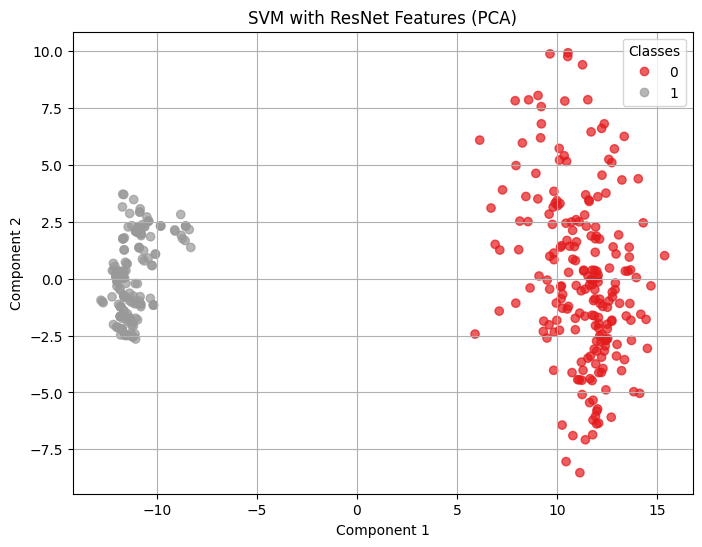

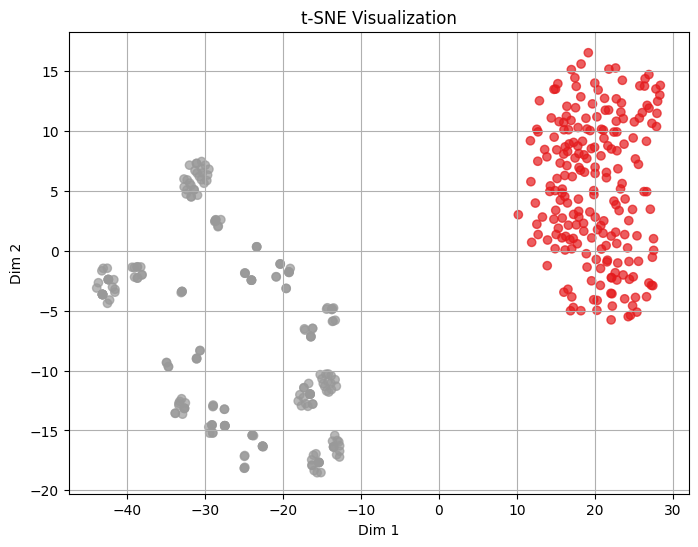

In [22]:


print("SVM trained.\nReport:")
print(classification_report(y_test, svm.predict(X_test)))


def plot_planes(X, y, title="Visualization"):
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="Set1", alpha=0.7)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.show()

plot_planes(X, y, "SVM with ResNet Features (PCA)")


tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap="Set1", alpha=0.7)
plt.title("t-SNE Visualization")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.show()

## Download the filter model

In [15]:

joblib.dump(svm, "filtro.joblib")

['filtro.joblib']